In [1]:
import wandb
import os
import re

import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style('darkgrid')
%matplotlib inline

color = sns.color_palette()

# Wideness

In [3]:
name = 'fgsm-mnist_fc_none_5000_0'

# check id
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
for run in runs:
    if run.name == name:
        run_id = run.id
        print(run.name, run.id)
        break

fgsm-mnist_fc_none_5000_0 18oyvxuk


In [36]:
# find runs
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
print(len(runs))

# for run in runs:
#     print(run.name)

44


In [3]:
ENV = 'mnist'
METHOD = 'fc'
LTD = ['none']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
SEED = 0

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N and seed == SEED:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['train_acc'] = history['train_acc'].dropna()
        temp['epoch'] = history['epoch'].dropna()
        temp['N'] = '${}$'.format(n)
        temp['seed'] = seed
        df = df.append(temp)
        
        best_train_acc = history['best_train_acc'].dropna().item() * 100
        best_test_acc = history['best_test_acc'].dropna().item() * 100
        print('{:20}\t{:.1f}\t{:.1f}'.format(run.name, best_train_acc, best_test_acc))

mnist_fc_none_20000_0	98.6	97.5
mnist_fc_none_1000_0	92.2	93.3
mnist_fc_none_50000_0	99.1	97.8
mnist_fc_none_5000_0	96.9	96.5
mnist_fc_none_200000_0	99.3	97.9
mnist_fc_none_10000_0	98.1	97.4
mnist_fc_none_100000_0	99.3	97.8
mnist_fc_none_2000_0	94.7	95.1


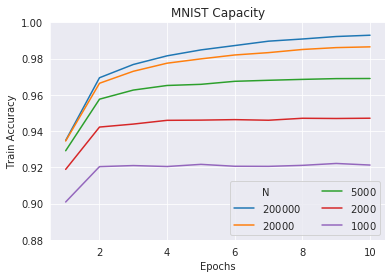

In [5]:
ax = sns.lineplot(x='epoch', y='train_acc', hue='N', ci=95, n_boot=10,
                  hue_order=['$200000$', '$20000$', '$5000$', '$2000$', '$1000$'],
                  data=df)
ax.set(title='MNIST Capacity', xlabel='Epochs', ylabel='Train Accuracy')
plt.ylim(0.88, 1.0)
plt.legend(loc='lower right', ncol=2)
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/wide_'+ENV+'.png', dpi=300)

In [6]:
ENV = 'fgsm-mnist'
METHOD = 'fc'
LTD = ['none']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
SEED = 0

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N and seed == SEED:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp['N'] = "${}$".format(n)
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = history['max_attack_acc'].dropna().item() * 100
        print('{:20}\t{:.1f}'.format(run.name, max_attack_acc))

fgsm-mnist_fc_none_200000_0	22.5
fgsm-mnist_fc_none_100000_0	18.0
fgsm-mnist_fc_none_50000_0	14.4
fgsm-mnist_fc_none_20000_0	17.5
fgsm-mnist_fc_none_10000_0	13.9
fgsm-mnist_fc_none_5000_0	16.6
fgsm-mnist_fc_none_2000_0	13.8
fgsm-mnist_fc_none_1000_0	9.4


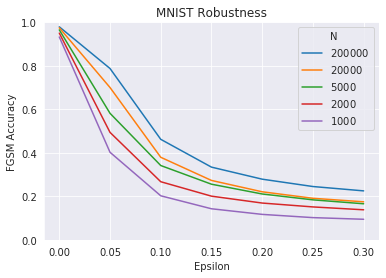

In [7]:
ax = sns.lineplot(x='eps', y='attack_acc', hue='N', ci=95, n_boot=10,
                  hue_order=['$200000$', '$20000$', '$5000$', '$2000$', '$1000$'],
                  data=df)
ax.set(title='MNIST Robustness', xlabel='Epsilon', ylabel='FGSM Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='upper right')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/wide_'+ENV+'.png', dpi=300)

# LTD

In [38]:
ENV = 'mnist'
METHOD = 'fc'
LTD = ['none', 'ma']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
SEED = 0

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    if m is not None:
        env = m.group(1)
        method = m.group(2)
        ltd = m.group(3)
        n = int(m.group(4))
        seed = int(m.group(5))

        if env == ENV and method == METHOD and ltd in LTD and n in N and seed == SEED:
            temp = pd.DataFrame()
            history = run.history(samples=1000)
            temp['train_acc'] = history['train_acc'].dropna()
            temp['epoch'] = history['epoch'].dropna()
            temp['N'] = '${}$'.format(n)
            temp['LTD'] = ltd
            temp['seed'] = seed
            df = df.append(temp)

            best_train_acc = history['best_train_acc'].dropna().item() * 100
            best_test_acc = history['best_test_acc'].dropna().item() * 100
            print('{:20}\t{:.1f}\t{:.1f}'.format(run.name, best_train_acc, best_test_acc))

KeyError: 'best_train_acc'

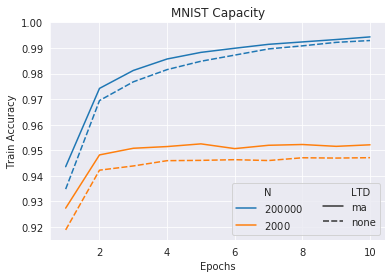

In [9]:
ax = sns.lineplot(x='epoch', y='train_acc', hue='N', style='LTD', ci=95, n_boot=10,
                  hue_order=['$200000$', '$2000$'],
                  data=df)
ax.set(title='MNIST Capacity', xlabel='Epochs', ylabel='Train Accuracy')
plt.ylim(0.915, 1.0)
plt.legend(loc='lower right', ncol=2)
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/ltd_'+ENV+'.png', dpi=300)

In [35]:
ENV = 'fgsm-mnist'
METHOD = 'fc'
LTD = ['none', 'ma']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
SEED = 0

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N and seed == SEED:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp['N'] = '${}$'.format(n)
        temp['ltd'] = ltd
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = history['max_attack_acc'].dropna().item() * 100
        print('{:30}\t{:.1f}'.format(run.name, max_attack_acc))

fgsm-mnist_fc_ma_200000_0     	65.8
fgsm-mnist_fc_ma_100000_0     	66.3
fgsm-mnist_fc_ma_50000_0      	66.6
fgsm-mnist_fc_ma_20000_0      	60.1
fgsm-mnist_fc_ma_10000_0      	56.2
fgsm-mnist_fc_ma_5000_0       	53.3
fgsm-mnist_fc_ma_1000_0       	30.9
fgsm-mnist_fc_ma_2000_0       	43.6


CommError: 'NoneType' object is not subscriptable

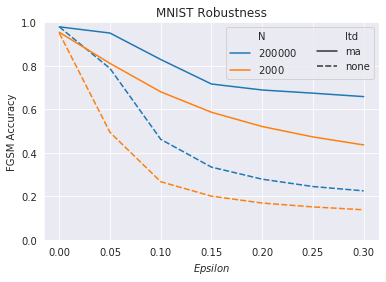

In [11]:
ax = sns.lineplot(x='eps', y='attack_acc', hue='N', style='ltd', ci=95, n_boot=10,
                  hue_order=['$200000$', '$2000$'],
                  data=df)
ax.set(title='MNIST Robustness', xlabel='Epsilon', ylabel='FGSM Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='upper right', ncol=2)
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/ltd_'+ENV+'.png', dpi=300)

# Sparseness and Inhibitory

In [25]:
ENV = 'mnist'
METHOD = 'rc'
LTD = ['ma']
K = [1, 2, 4, 10, 20, 50, 100, 200, 400, 784]
SEED = 0

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)-(.*)-(.*)_(.*)_(.*)_(.*)', run.name)
    if m is not None:
        env = m.group(1)
        method = m.group(2)
        k = int(m.group(3))
        golgi = m.group(4)
        ltd = m.group(5)
        n = int(m.group(6))
        seed = int(m.group(7))

        if env == ENV and method == METHOD and k in K and ltd in LTD and seed == SEED:
            temp = pd.DataFrame()
            history = run.history(samples=1000)

            temp['best_train_acc'] = history['best_train_acc'].dropna()
            temp['best_test_acc'] = history['best_test_acc'].dropna()
            temp['K'] = k
            temp['golgi'] = golgi
            temp['seed'] = seed
            df = df.append(temp)

            best_train_acc = history['best_train_acc'].dropna().item() * 100
            best_test_acc = history['best_test_acc'].dropna().item() * 100
            print('{:25}\t{:.1f}\t{:.1f}'.format(run.name, best_train_acc, best_test_acc))

mnist_rc-50-none_ma_68571_0	98.4	97.6
mnist_rc-2-none_ma_218182_0	94.8	94.9
mnist_rc-4-none_ma_200000_0	96.4	96.3
mnist_rc-10-none_ma_160000_0	97.6	97.2
mnist_rc-400-none_ma_11429_0	98.5	97.6
mnist_rc-200-none_ma_21818_0	98.7	97.7
mnist_rc-100-none_ma_40000_0	98.7	97.8
mnist_rc-20-none_ma_120000_0	98.0	97.4
mnist_rc-784-none_ma_5970_0	97.9	97.0
mnist_rc-1-none_ma_228571_0	91.0	91.4


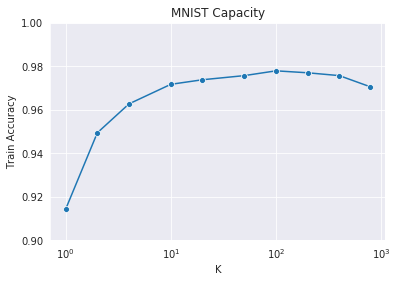

In [32]:
ax = sns.lineplot(x='K', y='best_test_acc', ci=95, n_boot=10, marker='o',
                  data=df)
ax.set(title='MNIST Capacity', xlabel='K', xscale='log', ylabel='Train Accuracy')
plt.ylim(0.9, 1.0)
# plt.legend(loc='lower right')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/sparse_'+ENV+'.png', dpi=300)

In [33]:
ENV = 'fgsm-mnist'
METHOD = 'rc'
LTD = ['ma']
K = [1, 2, 4, 10, 20, 50, 100, 200, 400, 784]
SEED = 0

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)-(.*)-(.*)_(.*)_(.*)_(.*)', run.name)
    if m is not None:
        env = m.group(1)
        method = m.group(2)
        k = int(m.group(3))
        golgi = m.group(4)
        ltd = m.group(5)
        n = int(m.group(6))
        seed = int(m.group(7))

        if env == ENV and method == METHOD and k in K and ltd in LTD and seed == SEED:
            temp = pd.DataFrame()
            history = run.history(samples=1000)

            temp['max_attack_acc'] = history['max_attack_acc'].dropna()
            temp['K'] = k
            temp['golgi'] = golgi
            temp['seed'] = seed
            df = df.append(temp)

            max_attack_acc = history['max_attack_acc'].dropna().item() * 100
            print('{:30}\t{:.1f}'.format(run.name, max_attack_acc))

fgsm-mnist_rc-784-none_ma_5970_0	55.1
fgsm-mnist_rc-100-none_ma_40000_0	73.0
fgsm-mnist_rc-200-none_ma_21818_0	69.3
fgsm-mnist_rc-20-none_ma_120000_0	77.6
fgsm-mnist_rc-400-none_ma_11429_0	60.0
fgsm-mnist_rc-50-none_ma_68571_0	73.3
fgsm-mnist_rc-10-none_ma_160000_0	82.4
fgsm-mnist_rc-4-none_ma_200000_0	75.5
fgsm-mnist_rc-2-none_ma_218182_0	68.0
fgsm-mnist_rc-1-none_ma_228571_0	49.3


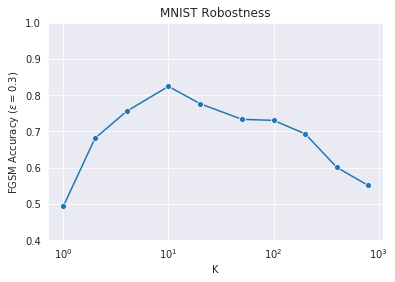

In [34]:
ax = sns.lineplot(x='K', y='max_attack_acc', ci=95, n_boot=10, marker='o',
                  data=df)
ax.set(title='MNIST Robostness', xlabel='K', xscale='log', ylabel='FGSM Accuracy ($\epsilon=0.3$)')
plt.ylim(0.4, 1.0)
# plt.legend(loc='lower right')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/sparse_'+ENV+'.png', dpi=300)

# Best Model